## Анализ базовой модели с помощью weightwatcher

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# ! pip uninstall numba -y && pip install numba

In [4]:
import os
import sys

# Получаем абсолютный путь к корневой директории проекта (директория выше текущей)
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Добавляем корневую директорию в sys.path
if root_path not in sys.path:
    sys.path.append(root_path)

In [5]:
from model_loaders import load_ss_model
import weightwatcher as ww
from pipeline import separate_audio
import torch
from models.clap_encoder import CLAP_Encoder
import IPython.display as ipd
from utils import parse_yaml
from utils import describe_weights
from torch import nn
import numpy as np
import pandas as pd

In [6]:
SS_CONFIG_PATH = '../config/audiosep_base.yaml'
CLAP_CKPT_PATH = '../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt'
AUDIOSEP_CKPT_PATH = '../checkpoint/audiosep_base_4M_steps.ckpt'
classes = ["bass", "drums", "vocals", "other musical instruments"]
device = torch.device('cuda')
configs = parse_yaml(SS_CONFIG_PATH)

In [7]:
query_encoder = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder).eval().to(device)

2024-05-04 21:05:53,777 - INFO - Loading HTSAT-base model config.
2024-05-04 21:05:55,774 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


# Ранг слоев AudioSep

In [8]:
from utils import calculate_ranks_of_conv_layers

# Вызываем функцию для расчета рангов
ranks = calculate_ranks_of_conv_layers(base_model.ss_model)
ranks

,layer_name,lower_dim_size,rank
0,base->pre_conv,1,1
1,base->encoder_block1->conv_block1->conv1,32,32
2,base->encoder_block1->conv_block1->conv2,32,32
3,base->encoder_block2->conv_block1->conv1,64,64
4,base->encoder_block2->conv_block1->conv2,64,64
5,base->encoder_block2->conv_block1->shortcut,32,32
6,base->encoder_block3->conv_block1->conv1,128,128
7,base->encoder_block3->conv_block1->conv2,128,128
8,base->encoder_block3->conv_block1->shortcut,64,64
9,base->encoder_block4->conv_block1->conv1,256,256


Видим, что ранг весовой матрицы равен её наименьшей размерности. Это означает, что сеть хорошо обучена

# Посмотрим на среднее alpha separation net

{'log_norm': 3.4622441728944704, 'alpha': 3.4710740844774923, 'alpha_weighted': 6.590802155253461, 'log_alpha_norm': 7.088332035155279, 'log_spectral_norm': 2.1900739450051367, 'stable_rank': 39.89981500874082}


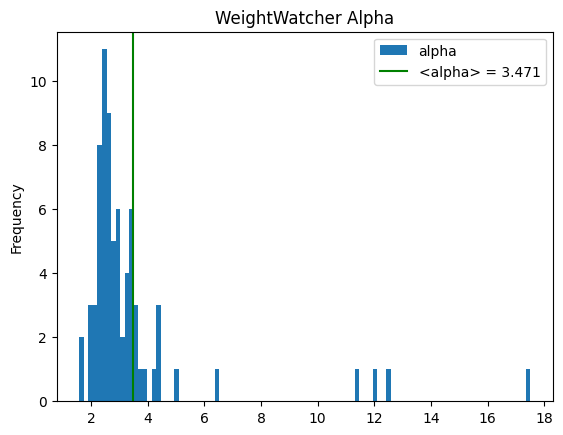

In [9]:
from utils import plot_hist

base_details, base_summary = describe_weights(base_model.ss_model)
plot_hist(base_details)
print(base_summary)

Видим, что модель хорошо обучена так как ее среднее alpha в районе 3.4, что больше 2 и меньше 6. Однако также есть несколько переобученных слоев (мешьше 2) и недообученных (больше 6)

# Посмотрим на среднее alpha query encoder

{'log_norm': 3.1513612377488123, 'alpha': 4.502124289611201, 'alpha_weighted': 6.452115787518112, 'log_alpha_norm': 6.795535441276522, 'log_spectral_norm': 1.603358336858141, 'stable_rank': 43.845841694528914}


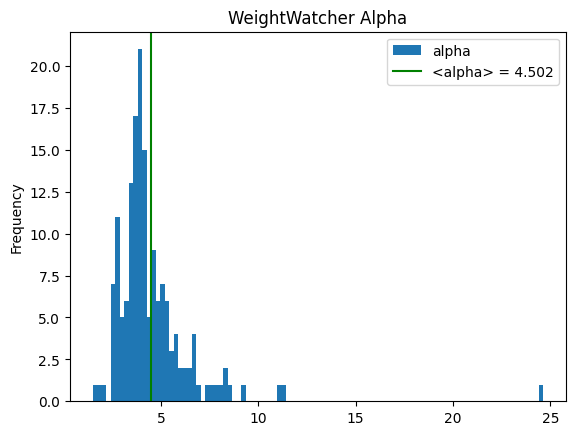

In [10]:
from utils import plot_hist

base_details, base_summary = describe_weights(base_model.query_encoder)
plot_hist(base_details)
print(base_summary)

alpha 4.5 в пределах "нормы", однако в отличии от separation net сеть имеет много недообученных слоев